# Pytorch开发深度学习模型一般步骤

## 1.定义DataSet
- 理解数据原始形式
- 理解数据编码方式
- 理解如何进行数据I/O

## 2.定义模型
- 定义各个子模块
- 将子模块合并成最终的模型

## 3.完成Train Pipeline/Valid Pipeline
- Pytorch一般的Train Pipeline/Valid Pipeline书写


In [4]:
import torch
from torch.utils.data import Dataset
import torch.utils.data as D
from torch import nn
import pandas as pd
import numpy as np
import copy
import os
from sklearn.metrics import roc_auc_score,log_loss
from tqdm import tqdm

In [5]:
#参数配置

config = {
    "data_path":'criteo.csv', #数据集路径（criteo数据集是二分类排序数据集，有26个离散特征，13个连续特征）
    "sparse_cols":[f'C{x}' for x in range(1,27)],
    "dense_cols" : [f'I{x}' for x in range(1,14)],
    "train_ratio" : 0.7, #70%用作训练集
    "valid_ratio" : 0.2, #20%用作验证集
    "debug_mode" : True, #true表明用很少数据作验证，反之用全量数据
    "epoch" : 5,
    "batch" : 1024,
    "lr" : 0.0001,
    "device" : -1, #-1表明用cpu，反之用相应位置的gpu
}

In [6]:
df = pd.read_csv(config['data_path'])

FileNotFoundError: [Errno 2] No such file or directory: 'criteo.csv'

In [22]:
df.head()

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,1.0,1,5.0,0.0,1382.0,4.0,15.0,2.0,181.0,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,-1,3a171ecb,c5c50484,e8b83407,9727dd16
1,0,2.0,0,44.0,1.0,102.0,8.0,2.0,2.0,4.0,...,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,-1,3a171ecb,43f13e8b,e8b83407,731c3655
2,0,2.0,0,1.0,14.0,767.0,89.0,4.0,2.0,245.0,...,8efede7f,3412118d,-1,-1,e587c466,ad3062eb,3a171ecb,3b183c5c,-1,-1
3,0,0.0,893,0.0,0.0,4392.0,0.0,0.0,0.0,0.0,...,1e88c74f,74ef3502,-1,-1,6b3a5ca6,-1,3a171ecb,9117a34a,-1,-1
4,0,3.0,-1,0.0,0.0,2.0,0.0,3.0,0.0,0.0,...,1e88c74f,26b3c7a7,-1,-1,21c9516a,-1,32c7478e,b34f3128,-1,-1


In [4]:
#如果是debug模式，只取前1000条数据处理
if config['debug_mode']:
    df = df[:1000]
#缺失值填充
df[config['sparse_cols']] = df[config['sparse_cols']].fillna('-1', )
df[config['dense_cols']] = df[config['dense_cols']].fillna(0, )
train_num = int(len(df)*config['train_ratio'])
valid_num = int(len(df)*config['valid_ratio'])
#切分数据集
train_df = df[:train_num].reset_index(drop=True)
valid_df = df[train_num:train_num+valid_num].reset_index(drop=True)
test_df = df[train_num+valid_num:].reset_index(drop=True)

## 1.定义DataSet
- 理解数据原始形式：为了之后把原始数据转化成模型能用的数据形式
- 理解数据编码方式：连续特征归一化，离散特征做mapping
- 理解如何进行数据I/O



In [5]:
#Dataset构造
class BaseDataset(Dataset):
    def __init__(self,config,df,enc_dict=None): #关键方法1:初始化
        self.config = config
        self.df = df
        self.enc_dict = enc_dict #原文中对应的vocabulary generator
        self.dense_cols = list(set(self.config['dense_cols']))
        self.sparse_cols = list(set(self.config['sparse_cols']))
        self.feature_name = self.dense_cols+self.sparse_cols+['label']

        #数据编码
        if self.enc_dict == None: #如果没有生成，则需要手动生成enc_dict
            self.get_enc_dict()
        self.enc_data()

    def get_enc_dict(self):
        #计算enc_dict
        self.enc_dict = dict(zip(list(self.dense_cols+self.sparse_cols),[dict() for _ in range(len(self.dense_cols+self.sparse_cols))]))
        for f in self.sparse_cols: #对于离散特征
            self.df[f] = self.df[f].astype('str') #全部转化成str，防止一些报错
            map_dict = dict(zip(self.df[f].unique(), range(1,self.df[f].nunique()+1))) #手动的映射
            self.enc_dict[f] = map_dict
            self.enc_dict[f]['vocab_size'] = self.df[f].nunique()+1 #+1是为了之后出现未知的离散特征
            '''
            eg:C17 特征的map_dict
            {'e5ba7672': 1,
             '07c540c4': 2,
             '8efede7f': 3,
             '1e88c74f': 4,
             '776ce399': 5,
             'd4bb7bd8': 6,
             '3486227d': 7,
             '27c07bd6': 8,
             '2005abd1': 9,
             'vocab_size': 10}
            '''

        for f in self.dense_cols: #对于连续特征
            self.enc_dict[f]['min'] = self.df[f].min()
            self.enc_dict[f]['max'] = self.df[f].max()
            '''
            eg:I6 特征
            {'min': 0.0, 'max': 4638.0}
            '''

        return self.enc_dict

    def enc_dense_data(self,col): #连续特征min-max归一化
        return (self.df[col] - self.enc_dict[col]['min']) / (self.enc_dict[col]['max'] - self.enc_dict[col]['min'])

    def enc_sparse_data(self,col): #离散特征映射操作
        return self.df[col].apply(lambda x : self.enc_dict[col].get(x,0)) #处理特征中的“新数据”：如果x不在key里，则返回0

    def enc_data(self):
        #使用enc_dict对数据进行编码
        self.enc_df = copy.deepcopy(self.df)
        for col in self.dense_cols:
            self.enc_df[col] = self.enc_dense_data(col)
        for col in self.sparse_cols:
            self.enc_df[col] = self.enc_sparse_data(col)

    def __getitem__(self, index): #关键方法2:获取第index条的数据
        data = dict()
        for col in self.feature_name:
            if col in self.dense_cols:
                data[col] = torch.Tensor([self.enc_df[col].iloc[index]]).squeeze(-1)
            elif col in self.sparse_cols:
                data[col] = torch.Tensor([self.enc_df[col].iloc[index]]).long().squeeze(-1)
        data['label'] = torch.Tensor([self.enc_df['label'].iloc[index]]).squeeze(-1) #记得加上标签
        return data

    def __len__(self): #关键方法3:获取数据长度
        return len(self.enc_df)

In [6]:
train_dataset = BaseDataset(config,train_df) #对train让其自己生成enc_dict
enc_dict = train_dataset.get_enc_dict()

#注意把train的enc_dict传给valid和test，保证数据一致性（即他们encoding形式是一样的）
valid_dataset = BaseDataset(config,valid_df,enc_dict=enc_dict)
test_dataset = BaseDataset(config,test_df,enc_dict=enc_dict)

In [8]:
train_dataset.__getitem__(5) #取第5条数据

{'I5': tensor(0.0144),
 'I11': tensor(0.),
 'I10': tensor(0.),
 'I6': tensor(0.),
 'I13': tensor(0.),
 'I9': tensor(0.0011),
 'I1': tensor(0.),
 'I7': tensor(0.),
 'I12': tensor(0.),
 'I4': tensor(0.),
 'I3': tensor(0.),
 'I8': tensor(0.),
 'I2': tensor(0.),
 'C20': tensor(3),
 'C23': tensor(3),
 'C24': tensor(6),
 'C17': tensor(5),
 'C6': tensor(4),
 'C15': tensor(6),
 'C9': tensor(1),
 'C18': tensor(6),
 'C21': tensor(6),
 'C5': tensor(2),
 'C14': tensor(3),
 'C19': tensor(2),
 'C22': tensor(3),
 'C7': tensor(6),
 'C25': tensor(2),
 'C10': tensor(3),
 'C1': tensor(4),
 'C3': tensor(6),
 'C4': tensor(6),
 'C2': tensor(6),
 'C13': tensor(6),
 'C8': tensor(2),
 'C16': tensor(6),
 'C26': tensor(3),
 'C11': tensor(6),
 'C12': tensor(6),
 'label': tensor(0.)}

In [24]:
enc_dict['I6']

{'min': 0.0, 'max': 4638.0}

In [7]:
#dataloader
train_loader = D.DataLoader(train_dataset,batch_size=config['batch'],shuffle=True,num_workers=0) #train的shuffle要是true，让每次batch里面的数据都是打乱的（false则从头到尾依次取到底）；num_workers是线程数量，0则默认一个
valid_loader = D.DataLoader(valid_dataset,batch_size=config['batch'],shuffle=False,num_workers=0)
test_loader = D.DataLoader(test_dataset,batch_size=config['batch'],shuffle=False,num_workers=0)

## 2.定义模型
- 定义各个子模块
- 将子模块合并成最终的模型

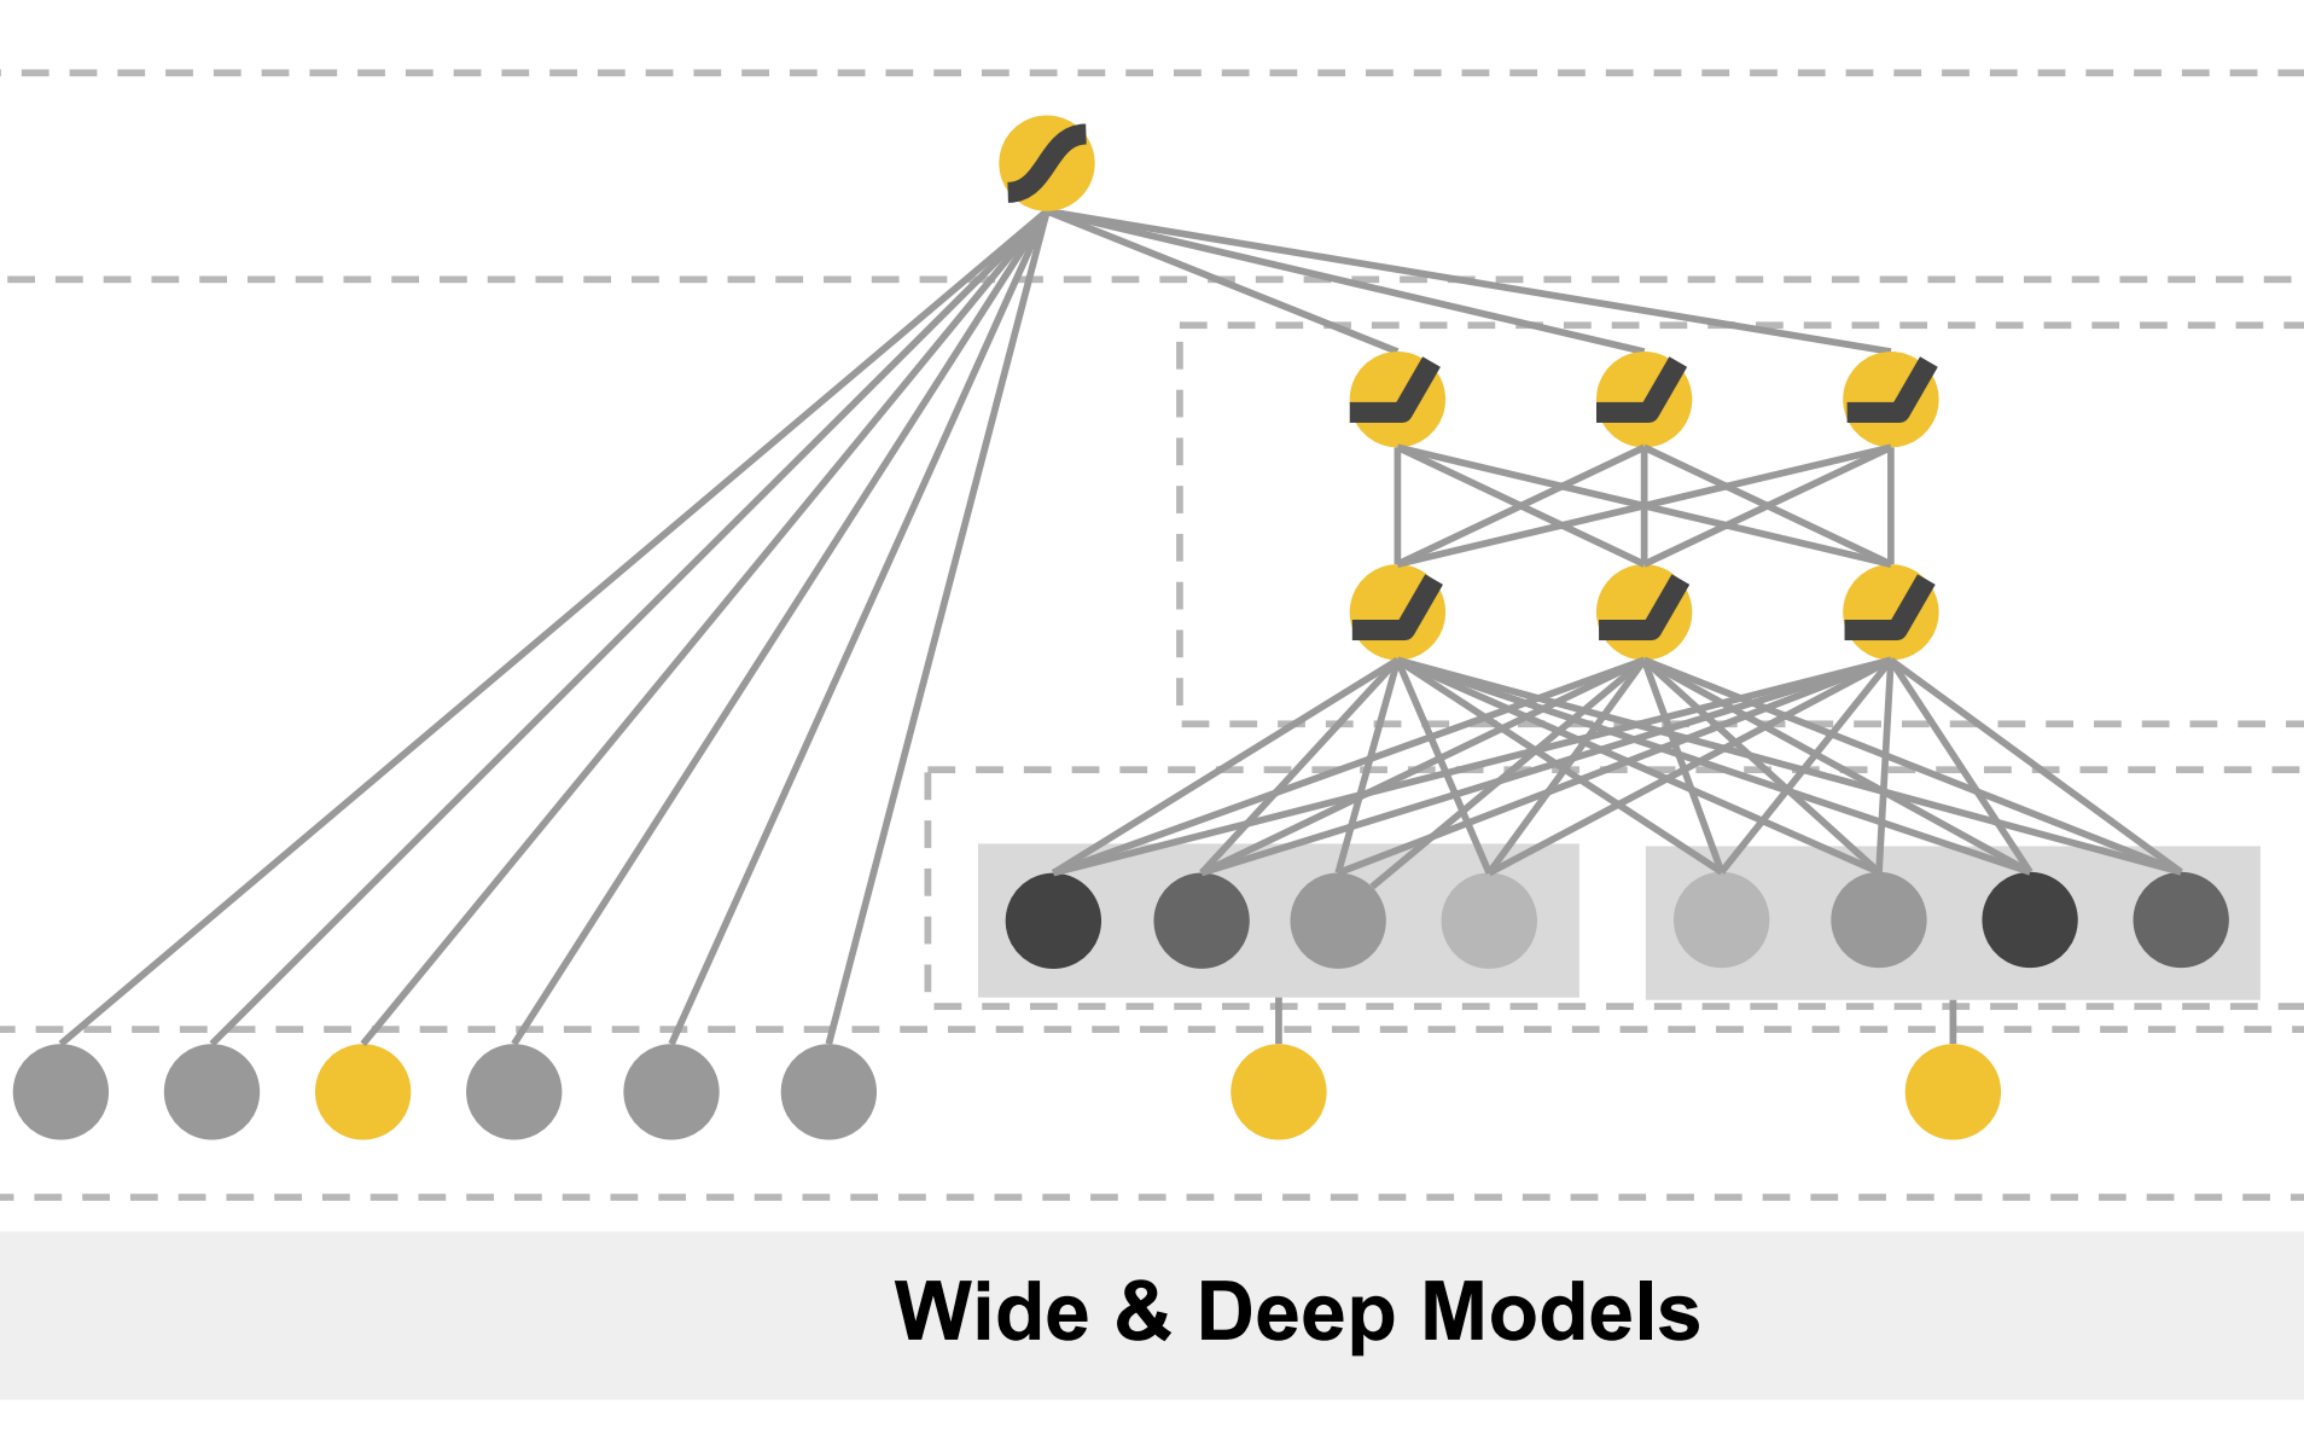

In [9]:
#基本网络模块

#通用Emb（最关键的子模块）
class EmbeddingLayer(nn.Module):
    def __init__(self,
                 enc_dict = None,
                 embedding_dim = None):
        super(EmbeddingLayer, self).__init__()
        self.enc_dict = enc_dict
        self.embedding_dim = embedding_dim
        self.embedding_layer = nn.ModuleDict()

        self.emb_feature = []

        for col in self.enc_dict.keys():
            if 'vocab_size' in self.enc_dict[col].keys(): #只有离散特征的key有vocab_size这个字段
                self.emb_feature.append(col)
                self.embedding_layer.update({col : nn.Embedding(
                    self.enc_dict[col]['vocab_size'], #一个长度为此数值的词表
                    self.embedding_dim,  #词表中每个词为维度为此数值的向量
                )})

    def forward(self, X):
        #对所有的sparse特征挨个进行embedding
        feature_emb_list = []
        for col in self.emb_feature:
            inp = X[col].long().view(-1, 1)
            feature_emb_list.append(self.embedding_layer[col](inp))
        return feature_emb_list
    

In [25]:
# emb = nn.Embedding(
#                     10, 
#                     32,
#                 )
# 

In [ ]:
# emb(torch.tensor(2)) #输入id为2，得到相应维度为32的向量

In [10]:
def set_device(gpu=-1):
    if gpu >= 0 and torch.cuda.is_available():
        os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu)
        device = torch.device(f"cuda:{gpu}")
    else:
        device = torch.device("cpu")
    return device
    
def set_activation(activation):
    if isinstance(activation, str):
        if activation.lower() == "relu":
            return nn.ReLU()
        elif activation.lower() == "sigmoid":
            return nn.Sigmoid()
        elif activation.lower() == "tanh":
            return nn.Tanh()
        else:
            return getattr(nn, activation)()
    else:
        return activation
    
def get_dnn_input_dim(enc_dict,embedding_dim):
    num_sparse = 0
    num_dense = 0
    for col in enc_dict.keys():
        if 'min' in enc_dict[col].keys():
            num_dense+=1
        elif 'vocab_size' in enc_dict[col].keys():
            num_sparse+=1
    return num_sparse*embedding_dim+num_dense #拼成一个大长条

def get_linear_input(enc_dict,data):
    res_data = []
    for col in enc_dict.keys():
        if 'min' in enc_dict[col].keys():
            res_data.append(data[col])
    res_data = torch.stack(res_data,axis=1)
    return res_data

In [11]:
#Wide部分：特征工程+lr
class LR_Layer(nn.Module):
    def __init__(self,enc_dict):
        super(LR_Layer, self).__init__()
        self.enc_dict = enc_dict
        self.emb_layer = EmbeddingLayer(enc_dict=self.enc_dict,embedding_dim=1) #embedding_dim=1意味着每个离散特征都映射成一个小数
        self.dnn_input_dim = get_dnn_input_dim(self.enc_dict, 1)
        self.fc = nn.Linear(self.dnn_input_dim,1)
        
    def forward(self,data):
        sparse_emb = self.emb_layer(data)
        sparse_emb = torch.stack(sparse_emb,dim=1).flatten(1) #[batch,num_sparse*emb]
        dense_input = get_linear_input(self.enc_dict, data)  #[batch,num_dense]
        dnn_input = torch.cat((sparse_emb, dense_input), dim=1) # [batch,num_sparse*emb + num_dense]
        out = self.fc(dnn_input)
        return out

In [12]:
#DNN部分
class MLP_Layer(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim=None,
                 hidden_units=[],
                 hidden_activations="ReLU",
                 final_activation=None,
                 dropout_rates=0,
                 batch_norm=False,
                 use_bias=True):
        super(MLP_Layer, self).__init__()
        dense_layers = []
        if not isinstance(dropout_rates, list):
            dropout_rates = [dropout_rates] * len(hidden_units)
        if not isinstance(hidden_activations, list):
            hidden_activations = [hidden_activations] * len(hidden_units)
        hidden_activations = [set_activation(x) for x in hidden_activations]
        hidden_units = [input_dim] + hidden_units
        for idx in range(len(hidden_units) - 1):
            dense_layers.append(nn.Linear(hidden_units[idx], hidden_units[idx + 1], bias=use_bias))
            if batch_norm:
                dense_layers.append(nn.BatchNorm1d(hidden_units[idx + 1]))
            if hidden_activations[idx]:
                dense_layers.append(hidden_activations[idx])
            if dropout_rates[idx] > 0:
                dense_layers.append(nn.Dropout(p=dropout_rates[idx]))
        if output_dim is not None:
            dense_layers.append(nn.Linear(hidden_units[-1], output_dim, bias=use_bias))
        if final_activation is not None:
            dense_layers.append(set_activation(final_activation))
        self.dnn = nn.Sequential(*dense_layers)  # * used to unpack list

    def forward(self, inputs):
        return self.dnn(inputs)

In [13]:
#Wide&Deep
class WDL(nn.Module):
    def __init__(self,
                 embedding_dim=40,
                 hidden_units=[64, 64, 64],
                 loss_fun = 'torch.nn.BCELoss()', #传参是字符串
                 enc_dict=None):
        super(WDL, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.hidden_units = hidden_units
        self.loss_fun = eval(loss_fun) #等价于self.loss_fun = torch.nn.BCELoss()，但这样写适用性更好
        self.enc_dict = enc_dict
        
        self.embedding_layer = EmbeddingLayer(enc_dict=self.enc_dict, embedding_dim=self.embedding_dim)
        #Wide部分
        self.lr = LR_Layer(enc_dict=self.enc_dict)
        # Deep部分
        self.dnn_input_dim = get_dnn_input_dim(self.enc_dict, self.embedding_dim) # num_sprase*emb + num_dense
        self.dnn = MLP_Layer(input_dim=self.dnn_input_dim, output_dim=1, hidden_units=self.hidden_units,
                                 hidden_activations='relu', dropout_rates=0)
        
    def forward(self,data):
        #Wide
        wide_logit = self.lr(data) #Batch,1

        #Deep
        sparse_emb = self.embedding_layer(data)
        sparse_emb = torch.stack(sparse_emb,dim=1).flatten(1) #[Batch,num_sparse_fea*embedding_dim]

        dense_input = get_linear_input(self.enc_dict, data)
        dnn_input = torch.cat((sparse_emb, dense_input), dim=1)#[Batch,num_sparse_fea*embedding_dim+num_dense]
        deep_logit = self.dnn(dnn_input)

        #Wide+Deep
        y_pred = (wide_logit+deep_logit).sigmoid()
        # 这里没有直接return y_pred，反而输出一个‘输出-loss’的字典，方便后面pipeline的复用

        #输出
        loss = self.loss_fun(y_pred.squeeze(-1),data['label'])
        output_dict = {'pred':y_pred,'loss':loss}
        return output_dict

## 3.完成Train Pipeline/Valid Pipeline
- Pytorch一般的Train Pipeline/Valid Pipeline书写

In [14]:
#训练模型，验证模型
def train_model(model, train_loader, optimizer, device, metric_list=['roc_auc_score','log_loss']):
    model.train()
    pred_list = []
    label_list = []
    loss_list = []
    pbar = tqdm(train_loader) #加个进度条
    for data in pbar: #等价于for data in train_loader:
        for key in data.keys():
            data[key] = data[key].to(device)

        output = model(data)
        pred = output['pred']
        loss = output['loss']
        loss_list.append(loss.item())

        loss.backward()
        optimizer.step()
        model.zero_grad()

        pred_list.extend(pred.squeeze(-1).cpu().detach().numpy())
        label_list.extend(data['label'].squeeze(-1).cpu().detach().numpy())
        pbar.set_description("Loss {}".format(np.mean(loss_list)))  #进度条展示内容的设置

    res_dict = dict()
    for metric in metric_list:
        if metric =='log_loss':
            res_dict[metric] = log_loss(label_list,pred_list, eps=1e-7)
        else:
            res_dict[metric] = eval(metric)(label_list,pred_list)

    return res_dict

def valid_model(model, valid_loader, device, metric_list=['roc_auc_score','log_loss']):
    model.eval() #开启模型的验证模式
    pred_list = []
    label_list = []
    #一般验证和测试时间没训练那么长，这里就没加进度条

    for data in (valid_loader):

        for key in data.keys():
            data[key] = data[key].to(device)

        output = model(data)
        pred = output['pred']

        pred_list.extend(pred.squeeze(-1).cpu().detach().numpy())
        label_list.extend(data['label'].squeeze(-1).cpu().detach().numpy())

    res_dict = dict()
    for metric in metric_list:
        if metric =='log_loss':
            res_dict[metric] = log_loss(label_list,pred_list, eps=1e-7)
        else:
            res_dict[metric] = eval(metric)(label_list,pred_list)

    return res_dict

def test_model(model, test_loader, device, metric_list=['roc_auc_score','log_loss']):
    model.eval()
    pred_list = []
    label_list = []

    for data in (test_loader):

        for key in data.keys():
            data[key] = data[key].to(device)

        output = model(data)
        pred = output['pred']

        pred_list.extend(pred.squeeze().cpu().detach().numpy())
        label_list.extend(data['label'].squeeze().cpu().detach().numpy())

    res_dict = dict()
    for metric in metric_list:
        if metric =='log_loss':
            res_dict[metric] = log_loss(label_list,pred_list, eps=1e-7)
        else:
            res_dict[metric] = eval(metric)(label_list,pred_list)

    return res_dict

In [18]:
model = WDL(enc_dict=enc_dict) #声明模型

In [19]:
device = set_device(config['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
model = model.to(device)
#模型训练流程
for i in range(config['epoch']):
    #模型训练
    train_metirc = train_model(model,train_loader,optimizer=optimizer,device=device)
    #模型验证
    valid_metric = valid_model(model,valid_loader,device)

    print("Train Metric:")
    print(train_metirc)
    print("Valid Metric:")
    print(valid_metric)
    
#测试模型
test_metric = test_model(model,test_loader,device)
print('Test Metric:')
print(test_metric)

Loss 0.6989568471908569: 100%|████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


Train Metric:
{'roc_auc_score': 0.5276016622515726, 'log_loss': 0.6989568114067827}
Valid Metric:


Loss 0.6953874230384827: 100%|████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


Train Metric:
{'roc_auc_score': 0.5289324678911753, 'log_loss': 0.6953874057105609}
Valid Metric:


Loss 0.6918538212776184: 100%|████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


Train Metric:
{'roc_auc_score': 0.5300498424376341, 'log_loss': 0.6918538122304848}
Valid Metric:


Loss 0.6883332133293152: 100%|████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


Train Metric:
{'roc_auc_score': 0.5310416692822438, 'log_loss': 0.688333251433713}
Valid Metric:


Loss 0.6848195791244507: 100%|████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Train Metric:
{'roc_auc_score': 0.5324980226236959, 'log_loss': 0.6848195437448366}
Valid Metric:
Test Metric:
{'roc_auc_score': 0.6386595434677027, 'log_loss': 0.6727463009953499}


In [20]:
test_metric

{'roc_auc_score': 0.6386595434677027, 'log_loss': 0.6727463009953499}